# Pixel clustering notebook

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import numpy as np
import pandas as pd
import xarray as xr

from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

### Set file paths and parameters

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from Segment_Image_Data.ipynb).
* `tiff_dir`: the path to the directory containing your imaging data
* `segmentation_dir`: the path to the directory containing your segmentations (generated from Segment_Image_Data.ipynb)

In [ ]:
base_dir = "../data/granulomaCohort_allData"
tiff_dir = os.path.join(base_dir, "TIFs")
segmentation_dir = "../data/granulomaCohort_allData"

* `preprocessed_dir`: the name of the directory to save the preprocessed pixel data (placed in base_dir)
* `subsetted_dir`: the name of the directory to save the subsetted pixel data (placed in base_dir)

In [ ]:
preprocessed_dir = 'pixel_mat_preprocessed'
subsetted_dir = 'pixel_mat_subsetted'

* `MIBItiff`: if the images in tiff_dir are mibitiff or not
* `mibitiff_suffix` (required if MIBItiff is True): the file suffix all mibitiff images contain

In [ ]:
MIBItiff = False
mibitiff_suffix = '-MassCorrected-Filtered.tiff'

* `fovs` (optional): set a specific set of fovs to load, default loads all the fovs in tiff_dir

In [ ]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov14"]

### Preprocess

* `channels`: set a subset to run pixel clustering over

In [ ]:
channels = ["CD45", "SMA", "Vimentin", "CD31", "Keratin-pan", "E-cadherin", "MastChyTry",
            "MPO", "CD20", "CD3", "CD14", "HLA-DR-DQ-DP", "Foxp3", "CD16", "CD11c", "CD206",
            "CD11b", "CD68", "CD163", "CD209"]

Set the following arguments

* `blur_factor`: the sigma to use for the Gaussian filter when running the Gaussian blur. Higher values are more aggressive in removing noise.
* `subset_proportion`: the percentage of pixels to take from each fov. Sampling is random.

In [ ]:
blur_factor = 2
subset_proportion = 0.1

In [ ]:
# run pixel data preprocessing
som_utils.create_pixel_matrix(
    fovs,
    channels,
    base_dir,
    tiff_dir,
    segmentation_dir,
    pre_dir=preprocessed_dir,
    sub_dir=subsetted_dir,
    is_mibitiff=MIBItiff,
    blur_factor=blur_factor,
    subset_proportion=subset_proportion
)

### Train pixel SOM

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for pixel clustering:

* `{cluster_prefix}_pixel_clustered_dir`: directory to store pixel data with just the SOM cluster assignments
* `{cluster_prefix}_pixel_consensus_dir`: directory to store pixel data with the SOM and consensus cluster assignments
* `{cluster_prefix}_pixel_weights_name`: file name to place the pixel SOM weights

In [ ]:
# explicitly set cluster_prefix to override datetime default
cluster_prefix = None

if cluster_prefix is None:
    cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

In [ ]:
# define the pixel SOM cluster, consensus cluster paths, and pixel SOM weights paths using specified prefix
pixel_clustered_dir = '%s_pixel_mat_clustered' % cluster_prefix
pixel_consensus_dir = '%s_pixel_mat_consensus' % cluster_prefix
pixel_weights_name = '%s_pixel_weights.feather' % cluster_prefix

For a full set of parameters you can customize for train_pixel_som, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_pixel_som

In [ ]:
# create the pixel-level SOM weights
som_utils.train_pixel_som(
    fovs,
    channels,
    base_dir,
    sub_dir=subsetted_dir,
    weights_name=pixel_weights_name,
    num_passes=10
)

### Assign pixel SOM clusters

In [ ]:
# use pixel SOM weights to assign pixel clusters
som_utils.cluster_pixels(
    fovs,
    base_dir,
    pre_dir=preprocessed_dir,
    weights_name=pixel_weights_name,
    cluster_dir=pixel_clustered_dir
)

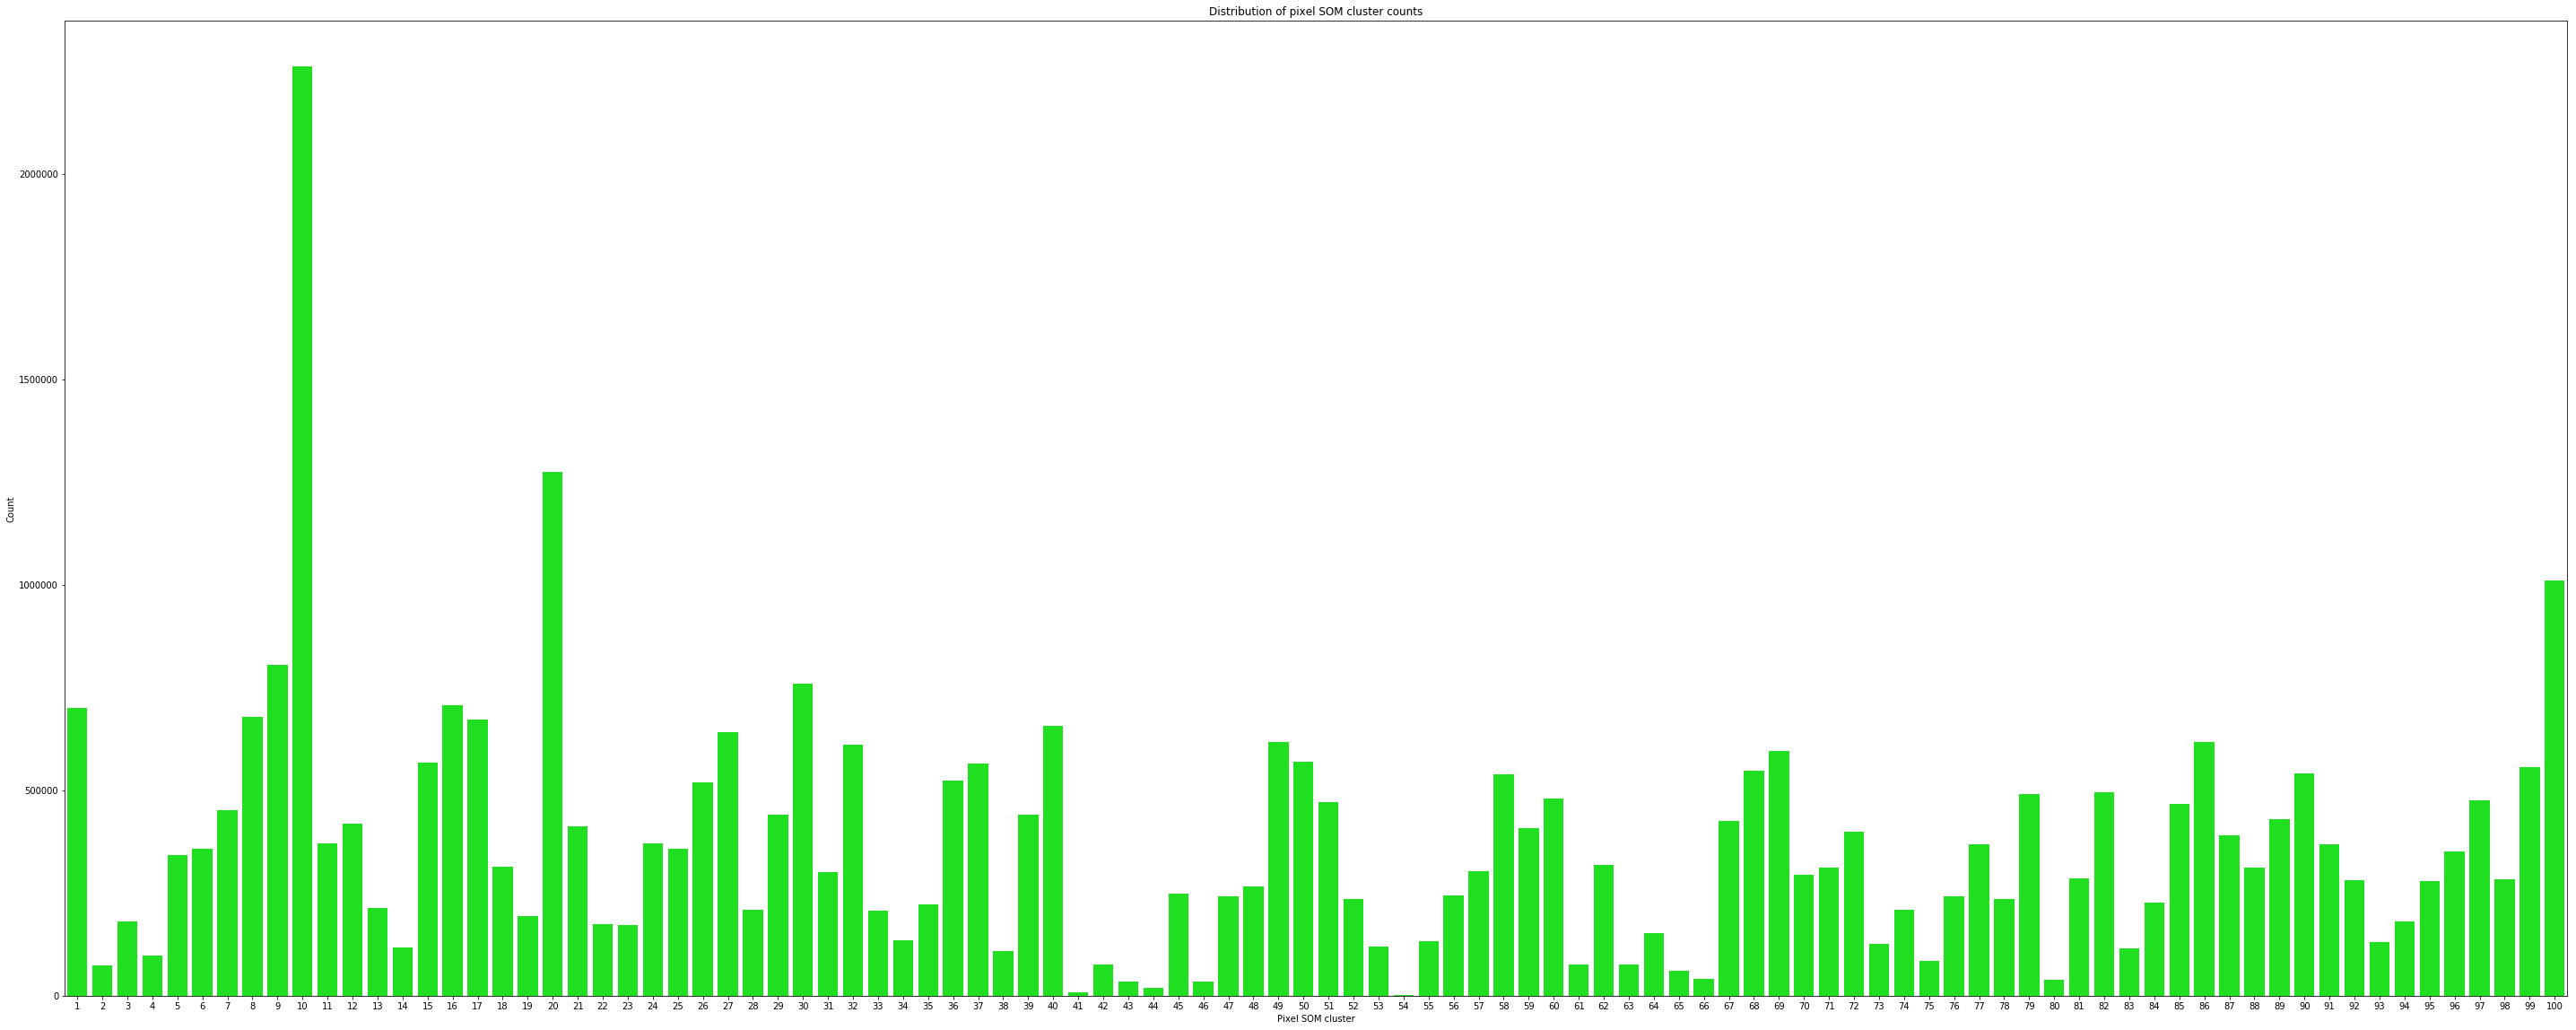

In [13]:
# visualize the number of pixels per SOM cluster
som_utils.visualize_pixel_cluster_counts(
    fovs,
    channels,
    base_dir,
    data_dir=pixel_clustered_dir,
    pixel_cluster_col='cluster'
)

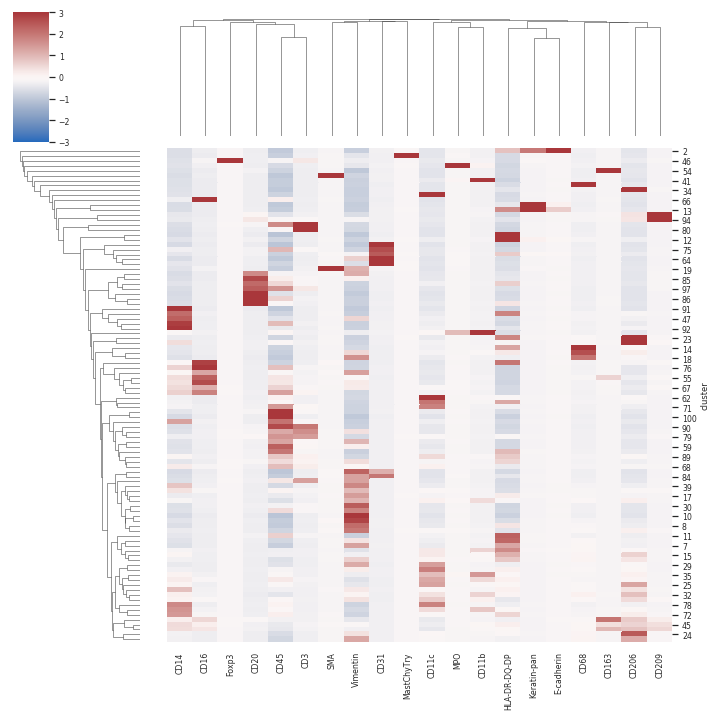

In [14]:
# visualize the pixel cluster average heatmap over channels (z-scored)
som_utils.visualize_pixel_cluster_channel_avgs(
    fovs,
    channels,
    base_dir,
    cluster_dir=pixel_clustered_dir,
    pixel_cluster_col='cluster',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

### Run pixel consensus clustering

For a full set of parameters you can customize for pixel_consensus_cluster, please consult: https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.pixel_consensus_cluster

In [ ]:
# run hierarchical clustering based on pixel SOM cluster assignments
som_utils.pixel_consensus_cluster(
    fovs,
    channels,
    base_dir,
    cluster_dir=pixel_clustered_dir,
    consensus_dir=pixel_consensus_dir
)

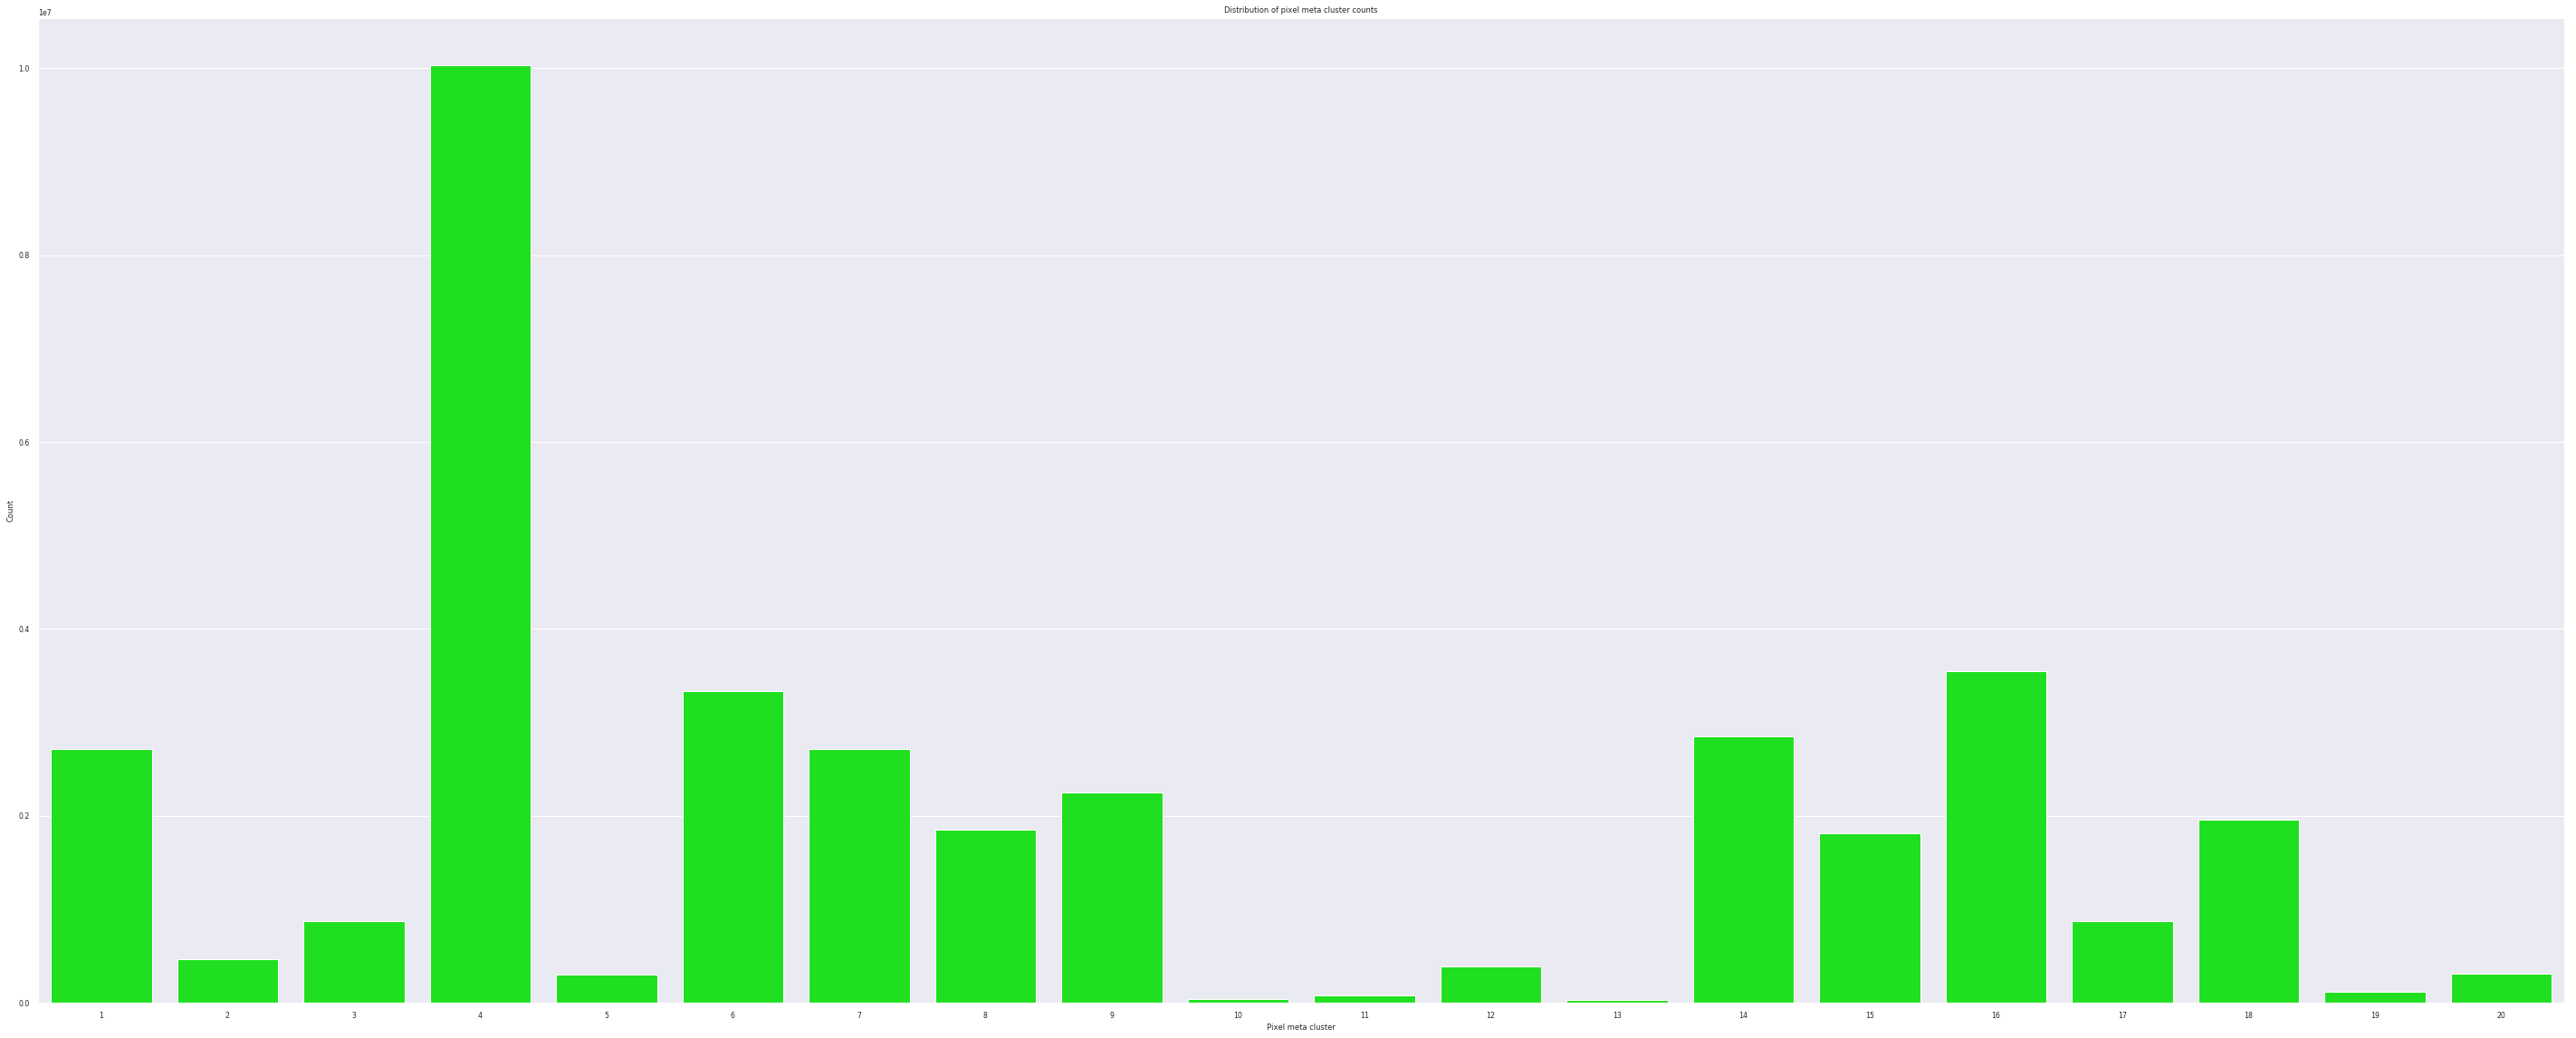

In [16]:
# visualize the number of pixels per meta cluster
som_utils.visualize_pixel_cluster_counts(
    fovs,
    channels,
    base_dir,
    data_dir=pixel_consensus_dir,
    pixel_cluster_col='hCluster_cap'
)

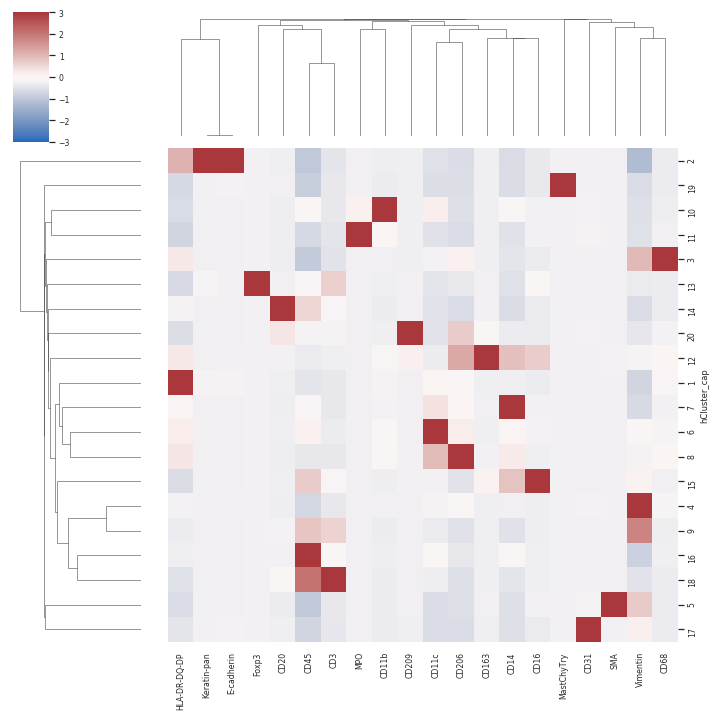

In [17]:
# visualize the pixel hierarchical cluster average heatmap over channels (z-scored)
som_utils.visualize_pixel_cluster_channel_avg(
    fovs,
    channels,
    base_dir,
    cluster_dir=pixel_consensus_dir,
    pixel_cluster_col='hCluster_cap',
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4)
)

### Visualize pixel cluster overlay

In [ ]:
# select fovs to display
pixel_fovs = ['fov6', 'fov7']

In [ ]:
# generate the pixel cluster masks for each fov in pixel_fovs
pixel_cluster_masks = data_utils.generate_pixel_cluster_mask(
    fovs,
    base_dir,
    segmentation_dir,
    pixel_consensus_dir=pixel_consensus_dir,
    cluster_col='cluster'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_pixel_mask.tiff` in `base_dir`

In [ ]:
save_pixel_masks = False

if save_pixel_masks:
    data_utils.save_fov_images(
        pixel_fovs,
        base_dir,
        pixel_cluster_masks,
        name_suffix='_pixel_mask'
    )

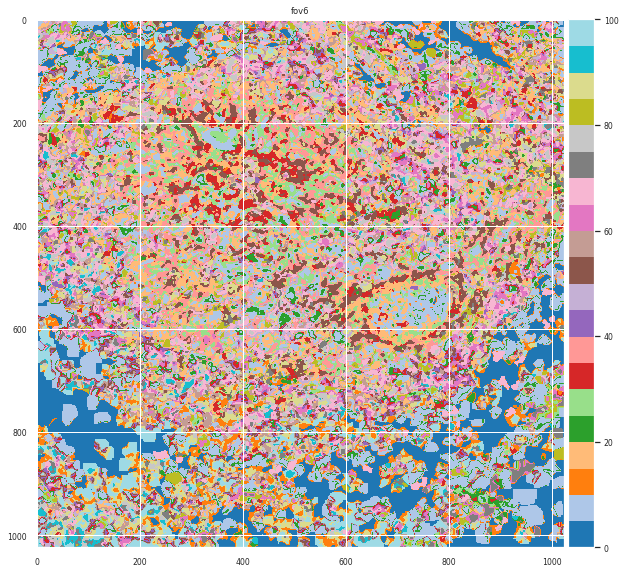

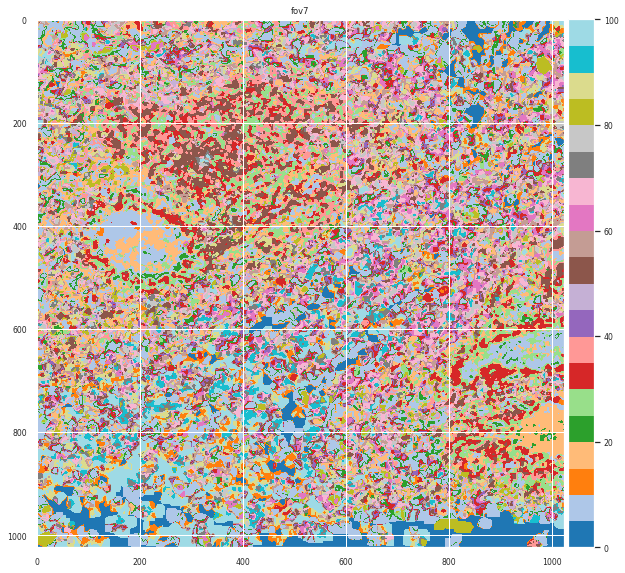

In [21]:
plot_utils.plot_clustering_result(
    pixel_cluster_masks,
    pixel_fovs
)

### Compute average channel values per pixel

* This will be used for interactive reclustering later
* Results are saved as `pixel_cluster_channel_avg.feather` in `base_dir`

`cluster_col`: whether to use pixel SOM or meta cluster counts for training. Set to 'cluster' or 'hCluster_cap' respectively

In [ ]:
cluster_col = 'cluster'

In [ ]:
# compute average cluster expression for each pixel som cluster
pixel_cluster_channel_avg = som_utils.compute_pixel_cluster_channel_avg(
    fovs, channels, base_dir, cluster_col, pixel_consensus_dir
)

In [ ]:
# save pixel_cluster_channel_avg
feather.write_dataframe(
    pixel_cluster_channel_avg, os.path.join(base_dir, 'pixel_cluster_avg.feather')
)